# Generate Interanual tDIC runoff forcing from Tank et al. 2012 Data

In [1]:
import os
import numpy as np
import pandas as pd
from struct import *
from MITgcmutils import mds
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap

In [2]:
import warnings
warnings.filterwarnings("ignore")

## I. Set path to data

In [3]:
# Set parameters
HDlist = os.listdir('/Volumes') 
HDsel = np.nan
HD = ["Proteus","Itsasorantz"]
# HD Selection
while not (HDsel==1 or HDsel==2):
    # While loop Intilization
    if not np.isnan(HDsel):
        print("Wrong choice ! Type 1 or 2")
    # Test Both HD pluged in case    
    if HD[0] in HDlist and HD[1] in HDlist:
        HDsel = int(input("Do you want to read data on (1) Proteus or (2) Itsasorantz ?"))
    # Selection for 1 HD pluged in
    elif HD[0] in HDlist:
        HDsel = 1
    elif HD[1] in HDlist:
        HDsel = 2
print(f"Reading data on {HD[HDsel-1]}")
HDpath = f"/Volumes/{HD[HDsel-1]}/"

Reading data on Itsasorantz


In [4]:
######### Parameters #########
# Number of vertical levels
vlvl = 46
# Input ells distribution (HDist or LDist)
dist = 'LDist'
# tDIC:tAlk ratio
rdicalk = .93

In [5]:
DatIn_pth = HDpath+'Data/Terr_exports/tDIC/LOADEST/'
Grd_pth = HDpath+'Modelling/Forcing/grids/G46x68x'+str(vlvl)+'/'
MacIn_pth = HDpath+'Data/ECCO-darwin/delta_inlets/mac270/'
Out_pth = HDpath+'Modelling/Forcing/river_runoff/Nutrients/Tank_etal_12/'

## II. Read tDIC data

### a. Read data

In [7]:
tDIC_df = pd.read_csv(DatIn_pth+'tDIC.csv', sep=';')[['Date','Cont Load Est (kgC/d)']]
tDIC_df = tDIC_df.set_index(pd.DatetimeIndex(tDIC_df['Date']))[['Cont Load Est (kgC/d)']]
tDIC_df.columns = ['Ld_DIC (kgC/d)']
Date = tDIC_df.index

### b. Convert Load from $kg.yr^{-1}$ to $mmol.s^{-1}$ and Weight channels

In [8]:
Sha_df = .298*tDIC_df
Bel_df = .376*tDIC_df
Kug_df = .326*tDIC_df

In [9]:
def convLd(LdIn):
    Mm = 12.0107
    d2s = 24*3600
    # Convert from kg/yr to mmol/s
    LdOut = (LdIn*1e6)/(Mm*d2s)
    return(LdOut)

In [11]:
Bay_ls = ['Ld_Sha','Ld_Bel', 'Ld_Kug'] # order of variable is important inlet 1=Shalow, etc.. 
for i in range(len(Bay_ls)):
    globals()[Bay_ls[i]+'an'] = convLd(globals()[Bay_ls[i][-3:]+'_df']['Ld_DIC (kgC/d)'].values)
    Clm_temp = globals()[Bay_ls[i][-3:]+'_df'].groupby([globals()[Bay_ls[i][-3:]+'_df'].index.month,
                                                        globals()[Bay_ls[i][-3:]+'_df'].index.day]).mean().values
    globals()[Bay_ls[i]+'Clim'] = convLd(Clm_temp[:,0])

### c. Read Mac270 grid data

In [12]:
# read mac270 grid
XC = mds.rdmds(Grd_pth+'XC')
YC = mds.rdmds(Grd_pth+'YC')
Vol = mds.rdmds(Grd_pth+'rAc')*mds.rdmds(Grd_pth+'dRF')[0]
print('Size of 1st vertical level = %.i m'%mds.rdmds(Grd_pth+'dRF')[0])
MaskC = mds.rdmds(Grd_pth+'maskInC')
# read mac270 inlets
inlet = np.load(MacIn_pth+'Inlets_'+dist+'.npy')

Size of 1st vertical level = 3 m


## III. Plot inlet situation

In [13]:
# Setup Mackenzie shelf Situation (Lambert Conformal basemap)
m = Basemap(width=400000,height=360000,projection='lcc',
            resolution='i',lat_1=69.,lat_2=71,lat_0=69.5,lon_0=-135.)
#Coordinates
parallels = np.arange(68.,72,1.)
meridians = np.arange(-141.,-120.,3.)

In [14]:
# Set elements for plot
col = ['tab:orange','tab:blue','tab:green']
Coor = np.array([np.meshgrid([-136.2,-135.4],[68.75,69.05]),np.meshgrid([-135.6,-135],[69.35,69.55]),
                 np.meshgrid([-134.1,-133.4],[69.25,69.5])])

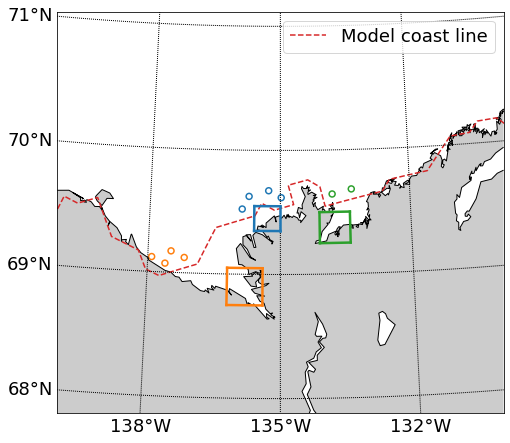

In [15]:
fig = plt.figure(figsize=(8,8))

###  Basemap coast   ###
m.drawcoastlines()
m.fillcontinents(color="#cccccc")
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=18) # (labels = [left,right,top,bottom])
m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=18) # (labels = [left,right,top,bottom])
###   Plot Model Coastline   ###
m.contour(XC, YC, MaskC, levels=[0], linestyles="--", colors='tab:red', latlon=True)
plt.legend(fontsize=18, handles=[Line2D([0], [0], color='tab:red',lw=1.5, 
                                        linestyle='--', label='Model coast line')], loc=1)

### Plot inlets ###
for i in range(3):
    ### Inlet Boxes
    m.plot(Coor[i][0],Coor[i][1], col[i], linewidth=2.5, latlon=True)
    m.plot(Coor[i][0].T,Coor[i][1].T, col[i], linewidth=2.5, latlon=True)
    ### Entry point
    id_temp = np.where(inlet==i+1)
    for j in range(len(id_temp[0])):
        m.scatter(XC[id_temp[0][j],id_temp[1][j]], YC[id_temp[0][j],id_temp[1][j]], latlon=True,
                 marker='o', facecolors='none', edgecolors=col[i], linewidths=1.5)

plt.show()

## IV. Create forcing matrixes

$r[mmol.m^{-3}.s^{-1}] = r[mmol.s^{-1}]*W$ 

where $W = \frac{1}{V.N}$ with:
- V = cell volume
- N = Number of entry cells for the outlet

In [16]:
# Create the W matrix
id_inlet = np.where(inlet>0)
N = np.ones(inlet.shape)
for i in range(int(inlet.max())):
    N[np.where(inlet==i+1)] = list(inlet[id_inlet]).count(i+1)
W = 1/(Vol*N)
W_exp = np.repeat(np.expand_dims(W,axis=0), len(Ld_Shaan),axis=0)

In [17]:
# Compute the runoff matrix
DICan_mac270 = np.zeros((len(Date),XC.shape[0],XC.shape[1]))
for j in range(len(id_inlet[0])):
    Ld_temp = globals()[Bay_ls[int(inlet[id_inlet[0][j],id_inlet[1][j]])-1]+'an']
    DICan_mac270[:,id_inlet[0][j],id_inlet[1][j]] = Ld_temp*W_exp[:,id_inlet[0][j],id_inlet[1][j]]
del Ld_temp

###### Verification plot

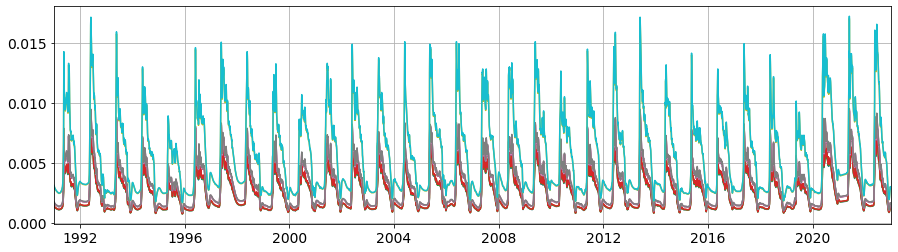

In [23]:
id_inlet = np.where(inlet>0)
plt.figure(figsize=(15,4))
for i in range(len(id_inlet[0])):
    plt.plot(Sha_df.index,DICan_mac270[:,id_inlet[0][i],id_inlet[1][i]])
plt.grid(True)
plt.tick_params(labelsize=14)
plt.xlim(Sha_df.index[0],Sha_df.index[-1])
plt.show()

## b. Climatological forcing

In [19]:
W_clim = np.repeat(np.expand_dims(W,axis=0), len(Ld_ShaClim),axis=0)

In [20]:
# Compute the runoff matrix
DICclim_mac270_bisex = np.zeros((len(Ld_ShaClim),XC.shape[0],XC.shape[1]))
for j in range(len(id_inlet[0])):
    Ld_temp = globals()[Bay_ls[int(inlet[id_inlet[0][j],id_inlet[1][j]])-1]+'Clim']
    DICclim_mac270_bisex[:,id_inlet[0][j],id_inlet[1][j]] = Ld_temp*W_clim[:,id_inlet[0][j],id_inlet[1][j]]
DICclim_mac270_norm = np.concatenate([DICclim_mac270_bisex[:59],DICclim_mac270_bisex[60:]])

###### Verification plot

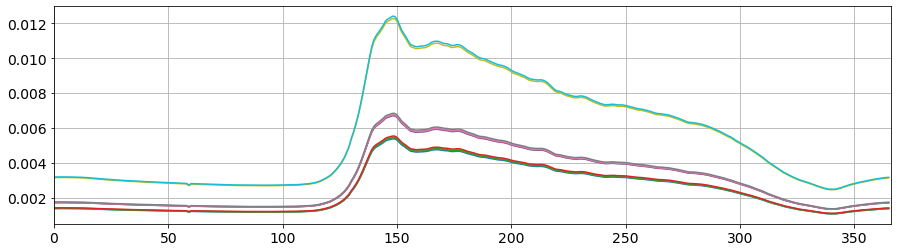

In [21]:
id_inlet = np.where(inlet>0)
plt.figure(figsize=(15,4))
for i in range(len(id_inlet[0])):
    plt.plot(DICclim_mac270_bisex[:,id_inlet[0][i],id_inlet[1][i]])
plt.grid(True)
plt.tick_params(labelsize=14)
plt.xlim(0,366)
plt.show()

## V. Save Forcing 

In [20]:
ch = input('Do you want to save the matrixes ? (y/n)')

Do you want to save the matrixes ? (y/n)y


In [21]:
def bin_save(fnm, array):
    newFile = open(fnm, "wb")
    bitearray = pack(">%sf" % len(array.flatten()),*array.flatten())
    newFile.write(bitearray);

### a. Create the folders

In [22]:
if ch =='y': 
    ##### Interannual #####
    Out_int_pth = Out_pth+'Interannual/r'+str(vlvl)+'/'+dist+'/'
    if not 'tDIC' in os.listdir(Out_int_pth):
        os.mkdir(Out_int_pth+'tDIC/')
    if not 'tAlk' in os.listdir(Out_int_pth):
        os.mkdir(Out_int_pth+'tAlk/')
    ##### Climatology #####
    Out_clm_pth = Out_pth+'Climatology/r'+str(vlvl)+'/'+dist+'/'
    if not 'tDIC' in os.listdir(Out_clm_pth):
        os.mkdir(Out_clm_pth+'tDIC/')
    if not 'tAlk' in os.listdir(Out_clm_pth):
        os.mkdir(Out_clm_pth+'tAlk/')

### b. Save interanual forcing matrix

In [23]:
if ch =='y': 
    for yr in list(set(Date.year)):
        bin_save(Out_int_pth+"tDIC/tDIC_runoff_mac270_"+str(yr), DICan_mac270[np.where(Date.year==yr)])
        bin_save(Out_int_pth+"tAlk/tAlk_runoff_mac270_"+str(yr), DICan_mac270[np.where(Date.year==yr)]*rdicalk)

### c. Save climatology forcing matrix

In [24]:
if ch =='y': 
    for yr in list(set(Date.year)):
        if len(np.where(Date.year==yr)[0]) == 366:
            bin_save(Out_clm_pth+"tDIC/tDIC_runoff_mac270_"+str(yr), DICclim_mac270_bisex)
            bin_save(Out_clm_pth+"tAlk/tAlk_runoff_mac270_"+str(yr), DICclim_mac270_bisex*rdicalk)
        else:
            bin_save(Out_clm_pth+"tDIC/tDIC_runoff_mac270_"+str(yr), DICclim_mac270_norm)
            bin_save(Out_clm_pth+"tAlk/tAlk_runoff_mac270_"+str(yr), DICclim_mac270_norm*rdicalk)